C:\Users\hp\AppData\Local\Temp\ipykernel_14524\1164565172.py:35: RuntimeWarning: overflow encountered in exp
  probabilities[k] = weights[k] * np.exp((-wk * distance)**2)


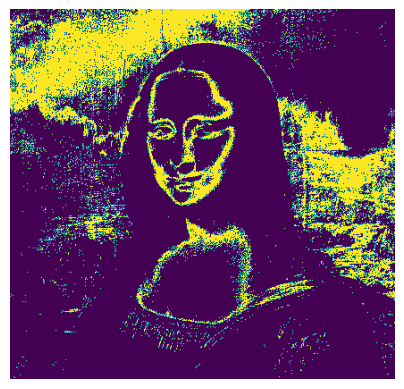

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def initialize_centroids(data, k):
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

def assign_to_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(data, clusters, k):
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            centroids[i] = cluster_points.mean(axis=0)
    return centroids

def kmeans(data, k, max_iters=100):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        clusters = assign_to_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return clusters, centroids

def compute_pixel_probability(pixel, cluster_centers, weights, wk):
    probabilities = np.zeros(len(cluster_centers))
    for k, center in enumerate(cluster_centers):
        distance = np.linalg.norm(pixel - center)
        probabilities[k] = weights[k] * np.exp((-wk * distance)**2)
    return np.sum(probabilities)

def foreground_background_likelihood(pixels, foreground_clusters, background_clusters, wk):
    pfg = np.zeros(len(pixels))
    pbg = np.zeros(len(pixels))

    for i, pixel in enumerate(pixels):
        pfg[i] = compute_pixel_probability(pixel, foreground_clusters, np.ones(len(foreground_clusters)), wk)
        pbg[i] = compute_pixel_probability(pixel, background_clusters, np.ones(len(background_clusters)), wk)

    return pfg, pbg

def segment_image(image, foreground_seed, background_seed, N=128, wk=0.1):
    # Perform K-Means clustering on the image
    data_points = np.reshape(image, (-1, 3))
    
    # Using scratch implementation of K-Means
    cluster_indices, cluster_centers = kmeans(data_points, N)
    
    # Extract seed pixels for foreground and background classes
    foreground_pixels = image[foreground_seed[:, 0], foreground_seed[:, 1]]
    background_pixels = image[background_seed[:, 0], background_seed[:, 1]]

    # Use K-Means to obtain N clusters for each class
    foreground_cluster_indices, foreground_cluster_centers = kmeans(foreground_pixels, N)
    background_cluster_indices, background_cluster_centers = kmeans(background_pixels, N)

    # Compute likelihoods
    pfg, pbg = foreground_background_likelihood(data_points, foreground_cluster_centers, background_cluster_centers, wk)

    # Assign pixels to classes
    segmented_image = np.zeros(len(data_points))
    segmented_image[pfg > pbg] = 1
    segmented_image = np.reshape(segmented_image, image.shape[:2])

    return segmented_image

# Load the image
image_path = "D:/Downloads/data/Q1 Dataset/Mona-lisa.PNG"
image = np.array(Image.open(image_path))

# Load the image containing the strokes
stroke_image_path = "D:/Downloads/data/Q1 Dataset/Mona-lisa stroke 2.PNG"
stroke_image = np.array(Image.open(stroke_image_path))

# Extract foreground and background seed pixels from the stroke image
tolerance = 10

# Extract foreground and background seed pixels from the stroke image
foreground_seed = np.argwhere(np.all(np.abs(stroke_image - [255, 0, 0]) < tolerance, axis=-1))
background_seed = np.argwhere(np.all(np.abs(stroke_image - [0, 0, 255]) < tolerance, axis=-1))

# Segment the image
segmented_image = segment_image(image, foreground_seed, background_seed)

# Visualize the segmented image
plt.imshow(segmented_image)
plt.axis('off')
plt.show()
